## Spatio-Temporal Deep Learning for FacePad

Step 1: Custom Data Loader with Augmentation

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from utils.dataloader import *


# Example usage
transform = transforms.Compose([
    AdaptiveCenterCropAndResize((224, 224)),  # Adaptive crop, resize, and convert to tensor
    # AdaptiveCenterCropAndResize((112, 112)),  # Adaptive crop, resize, and convert to tensor
    transforms.ToPILImage(),
    transforms.ToTensor(), 
])

dataset_path = 'D:/OneDrive - KFUPM/Proposals and Grants/SDAIA-KFUPM Joint Research Center for Artificial/SDAIA_ResearchGrant_face_PAD/Material/MobileNet_LSTM/Datasets'
# Instantiate dataset with augmentation enabled for training
train_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/train', transform=transform, num_frames=3, is_train=True, dataset_name='not-RA')
val_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu/devel', transform=transform, num_frames=1, is_train=False, dataset_name='not-RA')

# Instantiate dataloaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, pin_memory=True)


Step 2: Model Definition

In [2]:
from models.CNNTemporalAvgPooling import *
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = CNNTemporalAvgPooling(num_classes=2).to(device)

# # Example input (batch of videos with 16 frames of size 224x224)
example_input = torch.randn(4, 16, 3, 224, 224).to(device)

# Forward pass
output = model(example_input)
print(output.shape)  # Expected output shape: [batch_size, num_classes]


d:\anaconda3\envs\Py3126\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\Py3126\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 2])


Step 3: Training Code with TensorBoard, Early Stopping, Checkpointing, and tqdm

In [3]:
from utils.trainer import *
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Hyperparameters and setup
criterion = nn.CrossEntropyLoss()  # For final classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)


early_stopping_patience = 10  # Number of epochs to wait before stopping early
# Example usage with the training loop
num_epochs = 1

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping_patience, device)

Step 4: Visualize a Random Sample and its Class Label

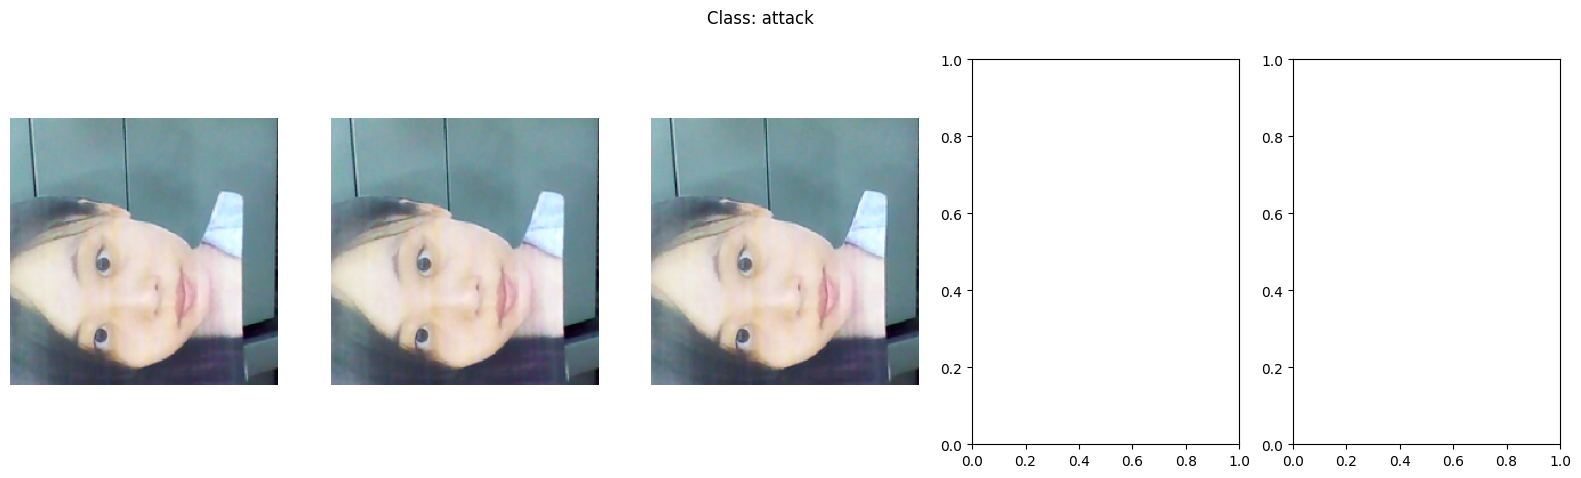

In [4]:
from utils.analysis_tools import *

# Visualize a random sample
visualize_sample(train_dataset)


Step 5: Evaluate on Test Dataset


--- Evaluation Summary ---
Test Loss: 0.8475
Test Accuracy: 27.08%
AUC-ROC: 0.1763
Equal Error Rate (EER): 0.7775
Half Total Error Rate (HTER): 0.5000
False Acceptance Rate (FAR): 0.0000
False Rejection Rate (FRR): 1.0000
Youden's Index (Max): 0.0000
Optimal Threshold (Youden's Index): inf
Average inference time per sample: 0.290407 seconds


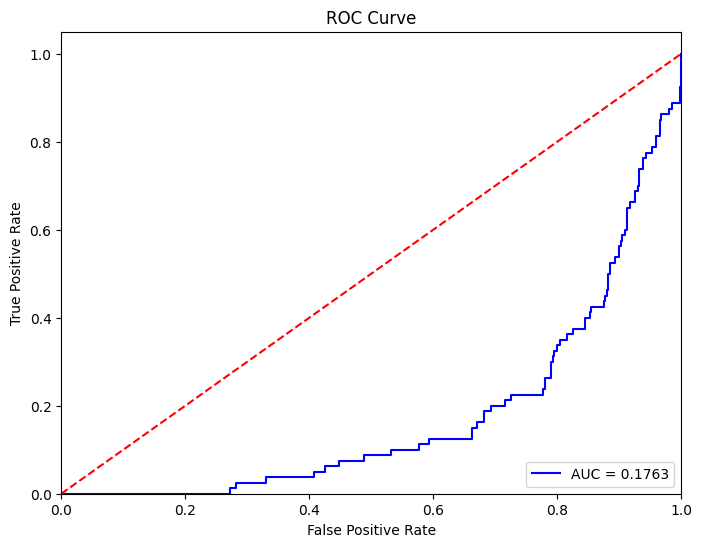

In [5]:
# Example usage
transform = transforms.Compose([
    # AdaptiveCenterCropAndResize((224, 224)),  # Adaptive crop, resize, and convert to tensor
    # AdaptiveCenterCropAndResize((112, 112)),  # Adaptive crop, resize, and convert to tensor
    AdaptiveCenterCropAndResize((56, 56)),  # Adaptive crop, resize, and convert to tensor
    transforms.ToPILImage(),
    transforms.ToTensor(), 
])

# test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=5, is_train=False)
# test_dataset = VideoDataset(root_dir=dataset_path+'/Replay-Mobile//test', transform=transform, num_frames=5, is_train=False)
test_dataset = VideoDataset(root_dir=dataset_path+'/Replay_Attack_mp4//test', transform=transform, num_frames=10, is_train=False, dataset_name='RA')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn, pin_memory=True)

# checkpoint = torch.load('current_model.pth', weights_only=True)
checkpoint = torch.load('checkpoints/best_model.pth', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# Assuming `evaluate` returns the results dictionary
results = evaluate_all(model, test_loader, criterion, device)

# Generate the summary and plot graphs
generate_evaluation_summary(results)


d:\anaconda3\envs\Py3126\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\anaconda3\envs\Py3126\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


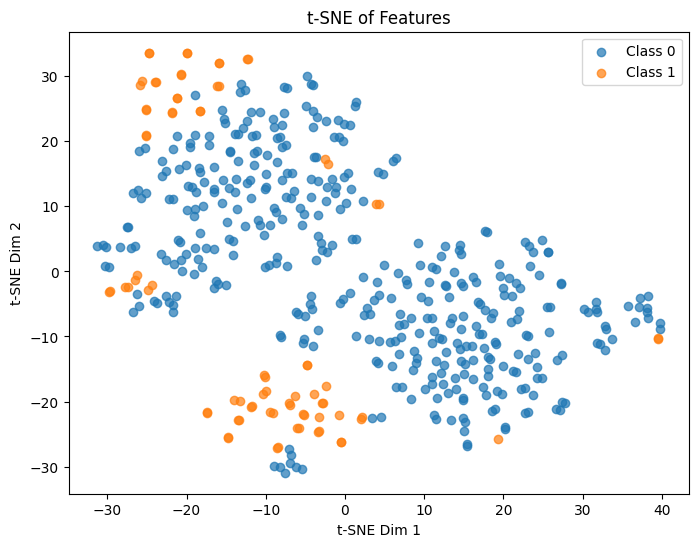

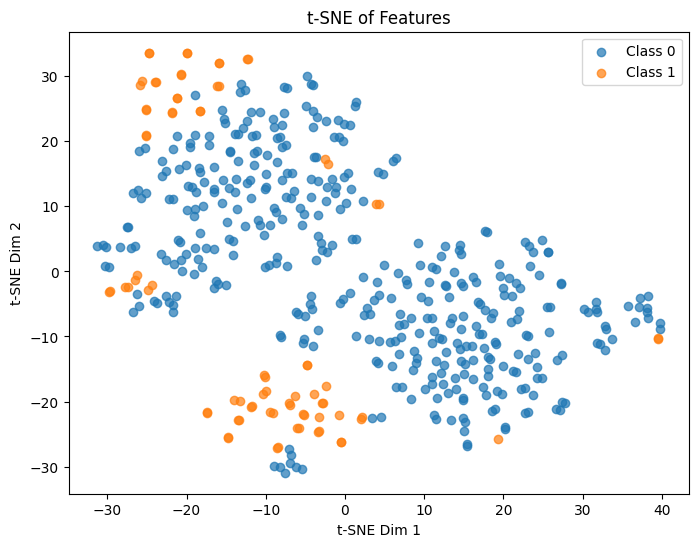

In [7]:

# test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=1)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)

# Visualize t-SNE before and after ATA
visualize_tsne_before_after_lstm(model, test_loader, device)

# test_dataset = VideoDataset(root_dir=dataset_path+'/Rose_Youtu//test', transform=transform, num_frames=10)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)


# Visualize t-SNE before and after ATA
visualize_tsne_before_after_lstm(model, test_loader, device)

